In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        policy = epsilon/(nA-1)*np.ones(nA)
        optimal = np.argmax(Q[observation])
        policy[optimal] = 1 - epsilon
        return policy
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n, np.int64))
    returns_count = defaultdict(lambda: np.zeros(env.action_space.n, np.int64))
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    for ep in range(num_episodes):
        if ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(ep, num_episodes), end="")
            sys.stdout.flush()
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        observation = env.reset()
        done = False
        state_list, count_list, act_list = [], [], []
        ep_rewards = 0
        count = 0
        while not done:
            count += 1
            action = np.random.choice(env.nA, p=policy(observation))
            
            if (observation, action) not in zip(state_list, act_list):
                state_list.append(observation)
                count_list.append(count)
                act_list.append(action)
            observation, reward, done, _ = env.step(action)
            ep_rewards += reward
            
        for state, occ, act in zip(state_list, count_list, act_list):
            returns_count[state][act] += 1
            returns_sum[state][act] += ep_rewards*discount_factor**(count-occ)
            Q[state][act] = returns_sum[state][act]/returns_count[state][act]
          
        
    return Q, policy

In [5]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

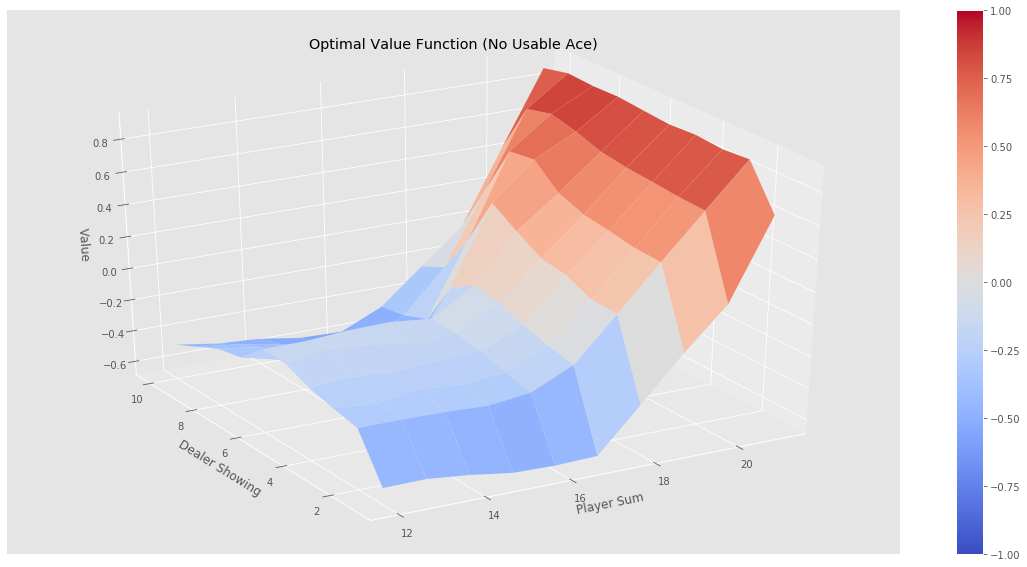

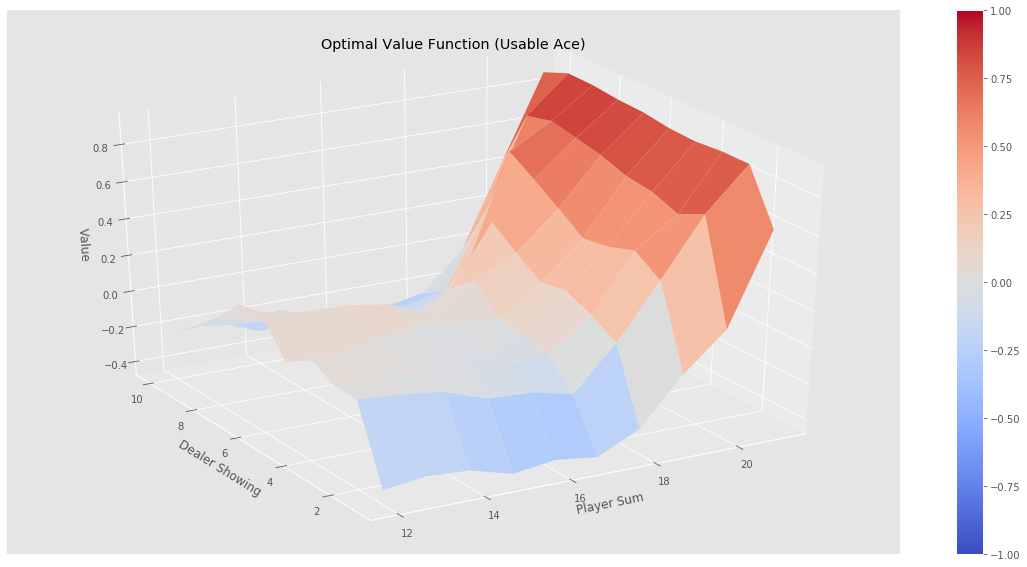

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state in Q.keys():
    actions = Q[state]
    action_value = np.max(actions)
    V[state] = action_value
  
    
plotting.plot_value_function(V, title="Optimal Value Function")